# README

## Introduction
Python code framework for modelling permanental process using IRL (on-going work). This inlcudes dependency to :
* <b>Tensorflow<b>
* <b>GPflow<b>: https://github.com/GPflow/GPflow



In [34]:
import numpy as np
import tensorflow as tf
float_type = tf.dtypes.float64

from point.low_rank_rff import LowRankRFF
from point.low_rank_nystrom import LowRankNystrom
from point.point_process import CoxLowRankSpatialModel
from point.misc import Space

import gpflow.kernels as gfk

rng = np.random.RandomState()

we are modeling Gaussian Process Cox process obtained by placing a GP prior on the intensity $\lambda$.

\begin{align}
&\lambda(\cdot) := (f(\cdot))^2 \\
&f \sim \mathcal{GP}(0,K(x,x')).
\end{align}
                   

## 1. <u> *LowRank* class </u>

The *LowRank* classes instanciate of low rank approximation representation of a $\mathcal{GP}$. Right now using :
* (1) *Random fourrier feature (LowRankRFF)*
* (2) *Nystrom Low Rank approximation (LowRankNystrom)*. 


### GP with Random fourrier feature 

yield $f$ being approximated by $f(x) \approx \sum_{i=0}^{R} \beta_i \varphi_i(x) $ where $\beta \sim\mathcal{N}(0, I)$ and $\varphi_i(x)$ denotes the random feature map. <br> Notice that the stochasticity of $f$ is controlled by the latent $\beta$.

The `LowRankRFF` class take as argument the Gaussian Kernel parameters `length_scale` (of dimension 2) and `variance`. The rank approximation is controlled by ` n_components`.

In [46]:
space = Space(-1,1)
variance = tf.Variable(5, dtype=float_type, name='sig')
length_scale = tf.Variable([0.5, 0.5], dtype=float_type, name='l')

In [47]:
lrgp_rff = LowRankRFF(length_scale, variance, n_components = 250, random_state = rng).fit()

<div class="alert alert-warning">
  <strong>Warning:</strong> Right now LowRankRFR is only implemented for Gaussian Kernel.
</div>

###  GP with Nystrom method 

approximate the Mercer Decompostion expression of the GP kernel. The eigenfunctions and eigenvalues are apprroximated from the SVD decomposition of a Gram matrix $K_n$ with entries obtained from inducing points $\{ x_n\}$ computed on a grid or by sampling (uniformly for the Lebesgue measure).  

\begin{equation}
f(x) \approx \sum_{i=0}^{R} w_i \Phi_i(x) 
 = k(x, {x}^{n})  U \Lambda^{-\frac{1}{2}}z
\end{equation}

where $U$ and $\Lambda$ denotes the matrices of eigenvectors and eigenvalues of $K_n$ respectively; the latent vector $z \sim\mathcal{N}(0, I)$.

The `LowRankNystrom` class is generic and can accepts as argument any *GPflow* kernel object (including composition of kernels). 

In [48]:
kernel = gfk.Matern12(variance= variance, lengthscales= length_scale)
lrgp_nyst = LowRankNystrom(kernel, n_components = 500, random_state = rng, noise = 1e-5, mode = 'grid').fit()

## Interface

Each *LowRank* object naturally re-sample a full intensity surfaces by sampling ore re-sampling the $\beta$ parameters.<br> This is controlled by the methods :
* `func(X)` return the GP evaluation for some inputs vector X ($n \times 2$) 
* `kernel(X, X=None)` return the Low rank estimation of the Gram matrix with entries *X*
* `sampling()` resample the latent variables and low rank feature random variables if any.

In [49]:
X = tf.constant(rng.normal(size = [500, 2]), dtype=float_type, name='inputs')
lambda_ = lrgp_rff.func(X)**2

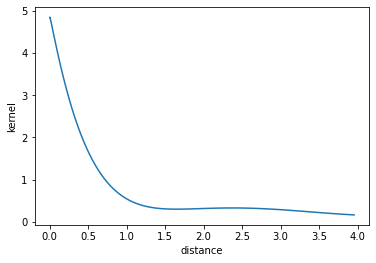

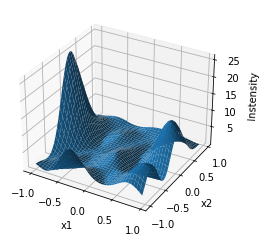

In [50]:
lrgp_rff.plot_kernel()
lrgp_rff.plot_surface()

## 2. <u> Cox Spatial Model <u>

The class `CoxLowRankSpatialModel` is the vanilla implementation of a Gaussian Process Cox process model. <br> A *LowRank* object is simply passed as argument.

In [40]:
process = CoxLowRankSpatialModel(lrgp_rff, random_state = rng)

Samples are generated by the method `generate`. A data structure containing the samples value is returned. If `calc_grad` is set to *True* the structure will also contain all the trainable parameters likelihood gradient (see below).

In [41]:
data = process.generate(space = space, batch_size = 3, calc_grad = False) 

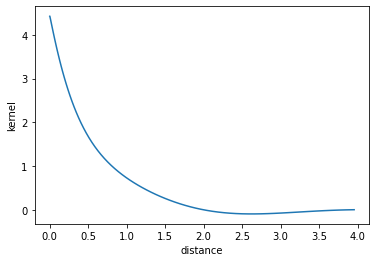

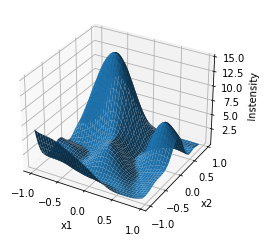

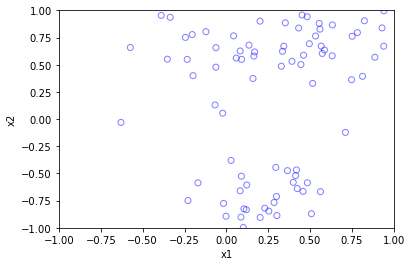

In [42]:
process.lrgp.plot_kernel()
process.lrgp.plot_surface()
data.plot_points(batch_index = 0)

The likelihood and likelihood gradient is obtained by `likelihood_grad(X)`. 


<div class="alert alert-info">
  <strong>Infos:</strong> The method uses the tensorflow <b>tf.GradientTape()</b> 
for AAD calculation of the gradient. 
</div>

In [43]:
points = data.points(batch_index = 0)
X =tf.constant(points, dtype=float_type, name='X')
out, grad = process.likelihood_grad(X, 1.0, -1.0)
print(grad)

(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 15.58976813, -70.4995194 ])>, <tf.Tensor: shape=(), dtype=float64, numpy=41.6702496474535>)


The method automatically return the gradient computation for the parameters set to be trainable. These can be accessed via the property method `trainable_variables`. Notice that a *Softplus* function is applied to some parameters to apply a positive constraint. In that case the gradient will be computed wrt the constrained variables. The unconstrained variables can be observed via `parameters`.

In [44]:
process.parameters

(<Parameter: dtype=float64, shape=[2], fn="softplus", numpy=array([0.5, 0.5])>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=5.0>)

In [45]:
process.trainable_variables

(<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([-0.43275213, -0.43275213])>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.993239250550512>)

## 3. <u>IRF training loop<u>

see the main script `main_script_training.py`.